In [ ]:
import warnings
import math

import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

import plotly.express as px

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Ботяра

бла бла бла

## Заполнение датафрэйма

Взял Сбер

In [ ]:
df = pd.read_csv('sr_full_date.csv', sep=",")
df = df.sort_values(by=['ticker', 'tradedate', 'tradetime']).drop_duplicates().reset_index().drop('index', axis=1)
df['datetime'] = pd.to_datetime(df['tradedate'] + ' ' + df['tradetime']) 
df = df.drop(['tradedate', 'tradetime'], axis=1) 
df = df[df['clgroup'] == 'YUR'].reset_index().drop('index', axis=1)
df = df[['datetime', 'pos']]
data_pos = df
#data_pos

In [ ]:
df = pd.read_csv('SR.csv', sep=",")
df.reset_index(inplace=True)

#df.columns = df.columns[1:].insert(16, 'index')
#df = df.iloc[:, :-1]
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df['datetime'] = df['datetime'].dt.strftime('%Y-%m-%d')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[['datetime', 'weighted_average_price_per_lot']]
df.rename(columns={'weighted_average_price_per_lot': 'price'}, inplace=True)
data_price = df
data_price

In [ ]:
price_dict = dict(zip(data_price['datetime'].dt.date, data_price['price']))

data_pos['price'] = data_pos['datetime'].dt.date.map(price_dict)

all_data = data_pos.sort_values('datetime').reset_index(drop=True)
all_data

## Выбросы

In [ ]:
all_data_copy = all_data.copy()

all_data_copy['date'] = all_data_copy['datetime'].dt.date
all_data_copy = all_data_copy[all_data_copy['date'] < pd.to_datetime('2021-11-01').date()]
df = all_data_copy.copy()
#print(df)

In [ ]:
fig = px.line(df, x='date', y='price', title='График цен по времени', labels={'date': 'Дата и время', 'price': 'Цена'})
fig.show()

In [ ]:
fig = px.line(df, x='datetime', y='pos', title='График цен по времени', labels={'datetime': 'Дата и время', 'pos': 'Цена'})
fig.update_xaxes(type='category')
fig.show()

In [ ]:
window_size = 9000  # Пример размера окна
df['pos_ma'] = df['pos'].rolling(window=window_size).mean()
mean_pos_ma = df['pos_ma'].mean()
std_pos_ma = df['pos_ma'].std()
pos_ma_upper = mean_pos_ma + 2 * std_pos_ma
pos_ma_lower = mean_pos_ma - 2.5 * std_pos_ma
print(mean_pos_ma, std_pos_ma)

In [ ]:
fig = px.line(df, x='datetime', y='pos_ma', title='График pos MA2000 по времени', labels={'datetime': 'Дата и время', 'pos_ma': 'Pos MA2000'})
fig.add_shape(
    dict(
        type="line",
        x0=df['datetime'].min(),
        x1=df['datetime'].max(),
        y0=pos_ma_upper,
        y1=pos_ma_upper,
        line=dict(color="green", width=2)
    )
)
fig.add_shape(
    dict(
        type="line",
        x0=df['datetime'].min(),
        x1=df['datetime'].max(),
        y0=pos_ma_lower,
        y1=pos_ma_lower,
        line=dict(color="red", width=2)
    )
)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
timestamps_up = []
timestamps_down = []

for i in range(len(df['pos_ma'])-1):
    if (df['pos_ma'][i + 1] > (pos_ma_upper)) and (df['pos_ma'][i] < (pos_ma_upper)):
        timestamps_up.append(df['datetime'][i + 1])
    elif (df['pos_ma'][i + 1] < (pos_ma_upper)) and (df['pos_ma'][i] > (pos_ma_upper)):
        timestamps_down.append(df['datetime'][i + 1])
    elif (df['pos_ma'][i + 1] < (pos_ma_lower)) and (df['pos_ma'][i] > (pos_ma_lower)):
        timestamps_down.append(df['datetime'][i + 1])
    elif (df['pos_ma'][i + 1] > (pos_ma_lower)) and (df['pos_ma'][i] < (pos_ma_lower)):
        timestamps_up.append(df['datetime'][i + 1])

timestamps_up = pd.to_datetime(timestamps_up)
timestamps_down = pd.to_datetime(timestamps_down)

print(timestamps_up)
print(timestamps_down)

In [ ]:
outliers_up = pd.DataFrame(columns=['datetime', 'pos', 'price', 'date'])
outliers_down = pd.DataFrame(columns=['datetime', 'pos', 'price', 'date'])
for i in range(len(df['pos'])-1):
    if (df['pos_ma'][i + 1] > (pos_ma_upper)) and (df['pos_ma'][i] < (pos_ma_upper)):
        outliers_up.loc[len(outliers_up)] = df.iloc[i + 1]
    elif (df['pos_ma'][i + 1] < (pos_ma_upper)) and (df['pos_ma'][i] > (pos_ma_upper)):
        outliers_down.loc[len(outliers_down)] = df.iloc[i + 1]
    elif (df['pos_ma'][i + 1] < (pos_ma_lower)) and (df['pos_ma'][i] > (pos_ma_lower)):
        outliers_down.loc[len(outliers_down)] = df.iloc[i + 1]
    elif (df['pos_ma'][i + 1] > (pos_ma_lower)) and (df['pos_ma'][i] < (pos_ma_lower)):
        outliers_up.loc[len(outliers_up)] = df.iloc[i + 1]

#print(outliers_up)
#print(outliers_down)

In [ ]:
fig = px.line(df, x='datetime', y='price', title='График цен по времени', labels={'datetime': 'Дата и время', 'price': 'Цена'})
fig.add_trace(px.scatter(outliers_up, x='datetime', y='price').update_traces(marker=dict(color='green')).data[0])
fig.add_trace(px.scatter(outliers_down, x='datetime', y='price').update_traces(marker=dict(color='red')).data[0])
fig.update_xaxes(type='category')
fig.show()

## Класс стратегии

In [ ]:
class MyPosition:

    def __init__(self, amount: float, price_current: float, short: bool):
        self._amount: float = amount
        self._price_current: float = price_current
        self._acc_fees: float = 0
        self._short: bool = short

    def update_state(self, price: float) -> None:
        self._price_current = price
        if self._short:
            self._acc_fees += abs(self._amount) * self._price_current * (0.00065) #комса за перенос короткой позиции

    def balance(self) -> float:
        return self._amount * self._price_current

    def __str__(self) -> str:
        return f"amount: {self._amount}, price_current: {self._price_current}"

    def __repr__(self) -> str:
        return self.__str__()


def create_position_by_notional(
            amount: float,
            price_current: float,
            short: bool
    ) -> MyPosition:

    return MyPosition(amount, price_current, short)

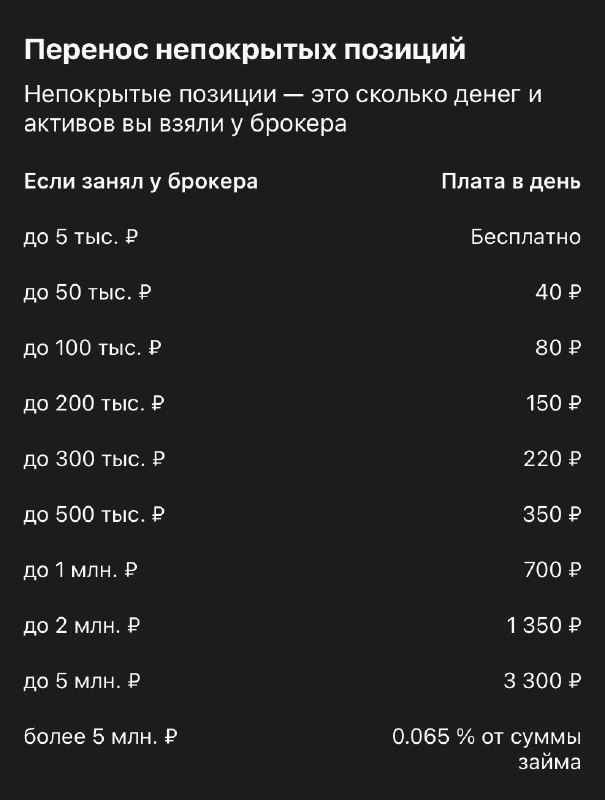

In [ ]:
class Strategy:

    params: dict = {
        'FEE': 0.00025, # Тариф начинающий
    }
     
    def __init__(self,
                 states: pd.DataFrame,
                 start_equity: float
                ):
        self._position: MyPosition = None
        self._states: pd.DataFrame = states
        self._data = []
        self._equity: float = start_equity
        self._margin_equity: float = 0

    def calc_timestamps(self, STD_COUNT_UP: int, STD_COUNT_DOWN: int, MA_COUNT: int) -> (pd.DatetimeIndex, pd.DatetimeIndex):

        window_size = MA_COUNT
        states: pd.Dataframe = self._states.copy()
        states['pos_ma'] = states['pos'].rolling(window=window_size).mean()

        mean_pos_ma = states['pos_ma'].mean()
        std_pos_ma = states['pos_ma'].std()

        pos_ma_upper = mean_pos_ma + STD_COUNT_UP * std_pos_ma
        pos_ma_lower = mean_pos_ma - STD_COUNT_DOWN * std_pos_ma

        timestamps_up = []
        timestamps_down = []
        
        for i in range(len(states['pos_ma'])-1):
            if (states['pos_ma'][i + 1] > (pos_ma_upper)) and (states['pos_ma'][i] < (pos_ma_upper)):
                timestamps_up.append(df['datetime'][i + 1])
            elif (states['pos_ma'][i + 1] < (pos_ma_upper)) and (states['pos_ma'][i] > (pos_ma_upper)):
                timestamps_down.append(df['datetime'][i + 1])
            elif (states['pos_ma'][i + 1] < (pos_ma_lower)) and (states['pos_ma'][i] > (pos_ma_lower)):
                timestamps_down.append(df['datetime'][i + 1])
            elif (states['pos_ma'][i + 1] > (pos_ma_lower)) and (states['pos_ma'][i] < (pos_ma_lower)):
                timestamps_up.append(df['datetime'][i + 1])

        return timestamps_up, timestamps_down

    def run(self, RISK: float, STD_COUNT_UP: int, STD_COUNT_DOWN: int, MA_COUNT: int):
        
        timestamps_up = []
        timestamps_down = []

        (timestamps_up, timestamps_down) = self.calc_timestamps(STD_COUNT_UP, STD_COUNT_DOWN, MA_COUNT)

        timestamps_up = pd.to_datetime(timestamps_up)
        timestamps_down = pd.to_datetime(timestamps_down)

        #print(timestamps_down, timestamps_up)
        for i, state in tqdm(self._states.iterrows()):
            if self._position:
                if self._states['price'][i] != self._states['price'][i-1]:
                    self._position.update_state(state['price'])
                if state['datetime'] in timestamps_up:
                    self.close_short()
                if state['datetime'] in timestamps_down:
                    self.close_long()
            else:
                if state['datetime'] in timestamps_up:
                    self.open_long(state, RISK)
                if state['datetime'] in timestamps_down:
                    self.open_short(state, RISK)
            

            self._data.append([
                state['datetime'],
                state['price'],
                self._equity
            ])

        return pd.DataFrame(self._data, columns=['datetime', 'price', 'equity'])
        
    def open_short(self, state, RISK: float):
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        if self._equity <= 0:
            raise Exception(f'Cannot open short position {self._equity}')
        
        self._margin_equity += (math.floor((1 - self.params['FEE']) * RISK * self._equity / state['price']) * state['price'] - self.params['FEE'] * self._equity)

        amount = (-1) * math.floor((1 - self.params['FEE']) * RISK * self._equity / state['price'])

        self._position = create_position_by_notional(
            amount = amount, 
            price_current = state['price'],
            short = True
        )
    
    def open_long(self, state, RISK: float):
        if self._position:
            raise Exception(f'Cannot open position, already have one {self._position}')

        if self._equity <= 0:
            raise Exception(f'Cannot open long position  balance = {self._equity}')

        self._margin_equity -= (math.floor((1 - self.params['FEE']) * RISK * self._equity / state['price']) * state['price'] + self.params['FEE'] * self._equity)

        amount = math.floor((1 - self.params['FEE']) * RISK * self._equity / state['price'])

        self._position = create_position_by_notional(
            amount = amount, 
            price_current = state['price'],
            short = False
        )

    def close_short(self):
        if self._position._short == 0:
            raise Exception(f'Cannot close short position, it is long')

        #print(self._margin_equity, (1 - self.params['FEE']) * self._position.balance(),  self._position._acc_fees)
        self._equity += (self._margin_equity + (1 - self.params['FEE']) * self._position.balance() - self._position._acc_fees)
        self._margin_equity = 0
        self._position = None

    def close_long(self):
        if self._position._short == 1:
            raise Exception(f'Cannot close long position, it is short')

        self._equity += (self._margin_equity + (1 - self.params['FEE']) * self._position.balance() - self._position._acc_fees)
        self._margin_equity = 0
        self._position = None

In [ ]:
strategy = Strategy(all_data_copy, 1000000)
data = strategy.run(0.05, 2, 2, 2000)
df = pd.DataFrame(data)
px.line(df, x='datetime', y=['equity'])

In [ ]:
import numpy as np
import plotly.express as px

std_counts = np.arange(1, 3, 0.5)


parameters = []
final_total_balances = []

for std_count in std_counts:
    strategy = Strategy(all_data_copy, 5000000)
    df = pd.DataFrame(strategy.run(risk, std_count_up, std_count_up, ma_count))
    df['total_balance'] = df['total_balance'] / df['total_balance'].iloc[0]
        
    parameters.append(std_count)
    final_total_balance = df['total_balance'].iloc[-1]
    final_total_balances.append(final_total_balance)

data = {'std_count': std_counts, 'total_balance': final_total_balances}
df = pd.DataFrame(data)

fig = px.line(df, x='std_count', y='total_balance')
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title='STD_COUNT', yaxis_title='Total Balance at End'))

fig.show()